<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [39]:
import pandas as pd
import numpy as np
# Nuestro paquete
import nlp

In [41]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweet

In [40]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [46]:
data_raw =  pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', names=col_names)

In [43]:
from nlp.preprocessing import convierte_a_minusculas, quitar_caracteres_html, reemplazar_urls, reemplazar_usuarios,\
quitar_hashtag, quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas, quitar_nonascii, \
separar_abreviaciones, remove_stopwords, oracion_raiz, modificar_etiqueta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
data = convierte_a_minusculas(data_raw)
data['text'] = data['text'].map(lambda s: quitar_caracteres_html(s))
data['text'] = data['text'].map(lambda s: reemplazar_urls(s))
data['text'] = data['text'].map(lambda s: reemplazar_usuarios(s))
data['text'] = data['text'].map(lambda s: quitar_hashtag(s))
data['text'] = data['text'].map(lambda s: quitar_RT(s))
data['text'] = data['text'].map(lambda s: quitar_caracteres_especiales(s))
data['text'] = data['text'].map(lambda s: quitar_letras_repetidas(s))
data['text'] = data['text'].map(lambda s: quitar_nonascii(s))
data['text'] = data['text'].map(lambda s: separar_abreviaciones(s))
data['text'] = data['text'].map(lambda s: remove_stopwords(s))
data['text'] = data['text'].map(lambda s: oracion_raiz(s))
data = modificar_etiqueta(data)

In [48]:
data['text_raw'] = data_raw['text']

In [90]:
data.to_csv("1600000_datos_limpios_sin_user_ni_url_sep.csv", sep="|", index=False, encoding="utf-8")


# Carga de datos limpios

In [2]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving 1600000_datos_limpios_sin_user_ni_url.csv to 1600000_datos_limpios_sin_user_ni_url (1).csv


In [91]:
data = pd.read_csv('1600000_datos_limpios_sin_user_ni_url.csv',
                 encoding='utf-8', engine='python', error_bad_lines=False)

In [92]:
print(data.shape)

(1600000, 8)


In [93]:
data.head()

,Unnamed: 0,target,ids,date,flag,user,text,raw_text
0,0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."


In [94]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0       0
target           0
ids              0
date             0
flag             0
user             0
text          8494
raw_text         0
dtype: int64


In [95]:
data = data[data.text.notna()]

In [96]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", data.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
raw_text      0
dtype: int64


In [99]:
len(data)

1591506

## Buscamos 20,000 datos para entrenar y 2 mil para probar que sean cercano a la misma longitud


## Entrenamos un Tokenizer

In [97]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [98]:
max_words = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.text)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 330671
[('go', 1), ('get', 2), ('day', 3), ('good', 4), ('work', 5), ('like', 6), ('love', 7), ('got', 8), ('today', 9), ('time', 10)]


In [142]:

# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(data.text)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

Tweet más pequeño 0 words.
Tweet más grande 27 words.
Longitud promedio: 4.96 +- 3.04 words.




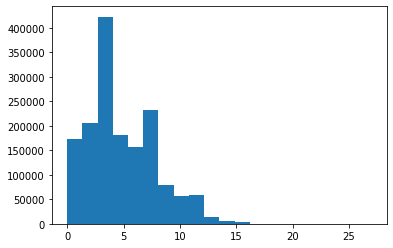

In [143]:
import matplotlib.pyplot as plt
plt.hist(lengths,20)
plt.show()

In [149]:
train_seq = np.array(train_sequences, dtype=object)
df_sequences = pd.DataFrame(train_seq.T, columns=['tokens'])

In [158]:
df_sequences['len'] = df_sequences['tokens'].map(lambda s: len(s))

In [154]:
data = data.reset_index().drop(['index', 'Unnamed: 0'], axis = 1)
data

,target,ids,date,flag,user,text,raw_text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,aww bummer shoulda got david carr third day,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...,is upset that he can't update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,dive mani time ball manag save 50 % rest go bo...,@kenichan i dived many times for the ball. man...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,behav mad see,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...,...
1591501,1,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feel ever,just woke up. having no school is the best fee...
1591502,1,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interview,thewdb.com - very cool to hear old walt interv...
1591503,1,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,readi mojo makeov ask detail,are you ready for your mojo makeover? ask me f...
1591504,1,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happi 38th birthday boo time tupac amaru shakur,happy 38th birthday to my boo of alll time!!! ...


In [155]:
df_sequences['target'] = data['target']

In [156]:
df_sequences

,tokens,target
0,"[110, 8, 697, 3]",0
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188]",0
2,"[221, 10, 860, 686, 495, 344, 1]",0
3,"[327, 645, 19, 6, 863]",0
4,"[454, 18]",0
...,...,...
1591501,"[248, 76, 103, 19, 149]",1
1591502,"[122, 174, 159, 752]",1
1591503,"[134, 287]",1
1591504,"[53, 183, 296, 10]",1


In [159]:
df_select = df_sequences[(df_sequences.len>9) & (df_sequences.len<11)]

In [160]:
df_select

,tokens,target,len
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188]",0,10
40,"[22, 19, 6, 2, 9, 8, 254, 42, 795, 203]",0,10
42,"[48, 48, 48, 17, 70, 19, 99, 31, 46, 27]",0,10
44,"[389, 441, 392, 112, 645, 231, 48, 372, 325, 251]",0,10
65,"[55, 224, 170, 218, 71, 380, 130, 979, 449, 319]",0,10
...,...,...,...
1591420,"[8, 76, 65, 31, 50, 2, 102, 486, 43, 232]",1,10
1591481,"[451, 152, 102, 365, 18, 28, 237, 290, 18, 316]",1,10
1591482,"[83, 11, 38, 378, 740, 238, 137, 440, 10, 25]",1,10
1591498,"[469, 146, 676, 514, 379, 10, 654, 74, 226, 219]",1,10


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


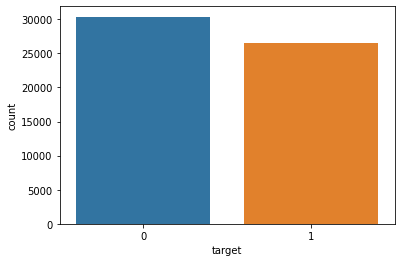

In [161]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(df_select['target'])

In [162]:
df_select.groupby('target').count()

,tokens,len
target,,
0,30376,30376
1,26556,26556


In [167]:
last_df = pd.concat([df_select[df_select.target==0].head(26556),df_select[df_select.target==1]], axis=0)

In [168]:
last_df 

,tokens,target,len
1,"[592, 222, 430, 353, 201, 242, 965, 76, 9, 188]",0,10
40,"[22, 19, 6, 2, 9, 8, 254, 42, 795, 203]",0,10
42,"[48, 48, 48, 17, 70, 19, 99, 31, 46, 27]",0,10
44,"[389, 441, 392, 112, 645, 231, 48, 372, 325, 251]",0,10
65,"[55, 224, 170, 218, 71, 380, 130, 979, 449, 319]",0,10
...,...,...,...
1591420,"[8, 76, 65, 31, 50, 2, 102, 486, 43, 232]",1,10
1591481,"[451, 152, 102, 365, 18, 28, 237, 290, 18, 316]",1,10
1591482,"[83, 11, 38, 378, 740, 238, 137, 440, 10, 25]",1,10
1591498,"[469, 146, 676, 514, 379, 10, 654, 74, 226, 219]",1,10


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


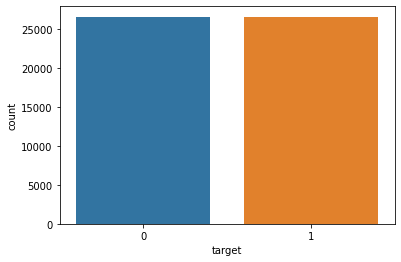

In [169]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(last_df['target'])

In [174]:
last_df.target

1          0
40         0
42         0
44         0
65         0
          ..
1591420    1
1591481    1
1591482    1
1591498    1
1591500    1
Name: target, Length: 53112, dtype: int64

# Hacemos padding

In [173]:
#sequences = tokenizer.texts_to_sequences(data_set_1.text)
max_len = 10
tweets = pad_sequences(list(last_df.tokens), maxlen=max_len, padding='post')
print(tweets)

[[592 222 430 ...  76   9 188]
 [ 22  19   6 ...  42 795 203]
 [ 48  48  48 ...  31  46  27]
 ...
 [ 83  11  38 ... 440  10  25]
 [469 146 676 ...  74 226 219]
 [ 75   5  69 ... 123   4 339]]


## Separamos en train, test

In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets, last_df.target.values, test_size=0.3, random_state=23042021)

In [177]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (37178, 10)
y_train (37178,)
X_test (15934, 10)
y_test (15934,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


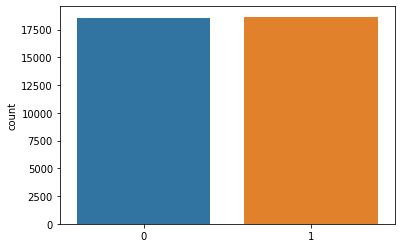

In [215]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


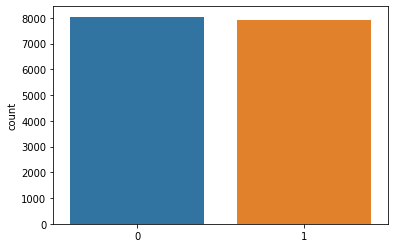

In [216]:
sns.countplot(y_test)

# Creamos el modelo

In [178]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1

### RNN, tomado de: https://www.kaggle.com/smitshah00/sentiment-analysis-ml-rnn

In [179]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         128000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 178,593
Trainable params: 178,593
Non-trainable params: 0
_________________________________________________________________


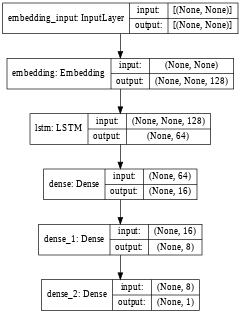

In [180]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [181]:
# Train
history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
465/465 [==============================] - 36s 7ms/step - loss: 0.6107 - accuracy: 0.6455 - val_loss: 0.5384 - val_accuracy: 0.7208
Epoch 2/10
465/465 [==============================] - 3s 7ms/step - loss: 0.5149 - accuracy: 0.7415 - val_loss: 0.5219 - val_accuracy: 0.7387
Epoch 3/10
465/465 [==============================] - 3s 7ms/step - loss: 0.4955 - accuracy: 0.7524 - val_loss: 0.5287 - val_accuracy: 0.7325
Epoch 4/10
465/465 [==============================] - 3s 6ms/step - loss: 0.4829 - accuracy: 0.7583 - val_loss: 0.5297 - val_accuracy: 0.7318
Epoch 5/10
465/465 [==============================] - 3s 6ms/step - loss: 0.4800 - accuracy: 0.7575 - val_loss: 0.5285 - val_accuracy: 0.7340
Epoch 6/10
465/465 [==============================] - 3s 6ms/step - loss: 0.4691 - accuracy: 0.7640 - val_loss: 0.5365 - val_accuracy: 0.7320
Epoch 7/10
465/465 [==============================] - 3s 7ms/step - loss: 0.4555 - accuracy: 0.7708 - val_loss: 0.5459 - val_accuracy: 0.7328
Epoch

In [183]:
model2.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 2ms/step - loss: 0.5760 - accuracy: 0.7248


[0.5759953260421753, 0.7248023152351379]

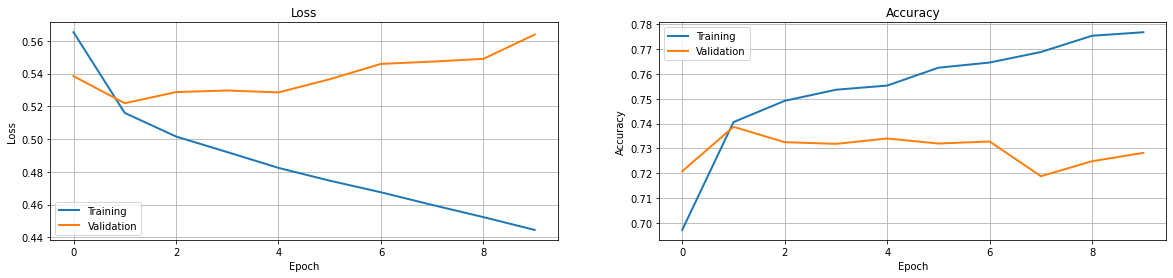

In [182]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [ ]:
#checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model2.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[checkpoint2])

## Con bidirectional

In [229]:
model2 = Sequential()
model2.add(Embedding(max_words, 128))
model2.add(Bidirectional(LSTM(64,dropout=0.5)))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_23 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 229,025
Trainable params: 229,025
Non-trainable params: 0
_________________________________________________________________


In [230]:
# Train
history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
465/465 [==============================] - 7s 10ms/step - loss: 0.6109 - binary_accuracy: 0.6519 - accuracy: 0.6519 - val_loss: 0.5299 - val_binary_accuracy: 0.7275 - val_accuracy: 0.7275
Epoch 2/10
465/465 [==============================] - 4s 8ms/step - loss: 0.5127 - binary_accuracy: 0.7430 - accuracy: 0.7430 - val_loss: 0.5222 - val_binary_accuracy: 0.7344 - val_accuracy: 0.7344
Epoch 3/10
465/465 [==============================] - 4s 8ms/step - loss: 0.4949 - binary_accuracy: 0.7510 - accuracy: 0.7510 - val_loss: 0.5259 - val_binary_accuracy: 0.7321 - val_accuracy: 0.7321
Epoch 4/10
465/465 [==============================] - 4s 9ms/step - loss: 0.4853 - binary_accuracy: 0.7572 - accuracy: 0.7572 - val_loss: 0.5274 - val_binary_accuracy: 0.7312 - val_accuracy: 0.7312
Epoch 5/10
465/465 [==============================] - 4s 8ms/step - loss: 0.4747 - binary_accuracy: 0.7625 - accuracy: 0.7625 - val_loss: 0.5285 - val_binary_accuracy: 0.7289 - val_accuracy: 0.7289
Epoch 6/1

In [231]:
model2.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.5819 - binary_accuracy: 0.7108 - accuracy: 0.7108


[0.5818944573402405, 0.7108070850372314, 0.7108070850372314]

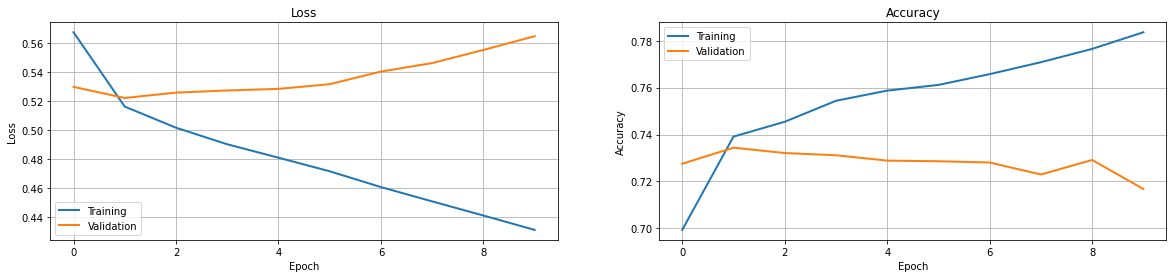

In [232]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Nuestro

In [187]:
model3 = Sequential()
model3.add(Embedding(max_words, 40, input_length=max_len))
model3.add(Bidirectional(layers.LSTM(20,dropout=0.6)))
model3.add(Dense(16,activation='relu'))
model3.add(Dense(1,activation='tanh'))

model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 40)            40000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


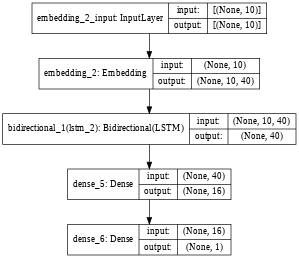

In [188]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [189]:
# Train
history = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
465/465 [==============================] - 7s 9ms/step - loss: 6.0184e-08 - accuracy: 0.4951 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 2/10
465/465 [==============================] - 3s 7ms/step - loss: 5.9965e-08 - accuracy: 0.4970 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 3/10
465/465 [==============================] - 3s 7ms/step - loss: 5.9939e-08 - accuracy: 0.4972 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 4/10
465/465 [==============================] - 3s 7ms/step - loss: 5.9786e-08 - accuracy: 0.4985 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 5/10
465/465 [==============================] - 3s 7ms/step - loss: 6.0144e-08 - accuracy: 0.4955 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 6/10
465/465 [==============================] - 3s 7ms/step - loss: 5.9959e-08 - accuracy: 0.4970 - val_loss: 5.9909e-08 - val_accuracy: 0.4974
Epoch 7/10
465/465 [==============================] - 3s 7ms/step - loss: 6.0199e-08 - accuracy: 0.4

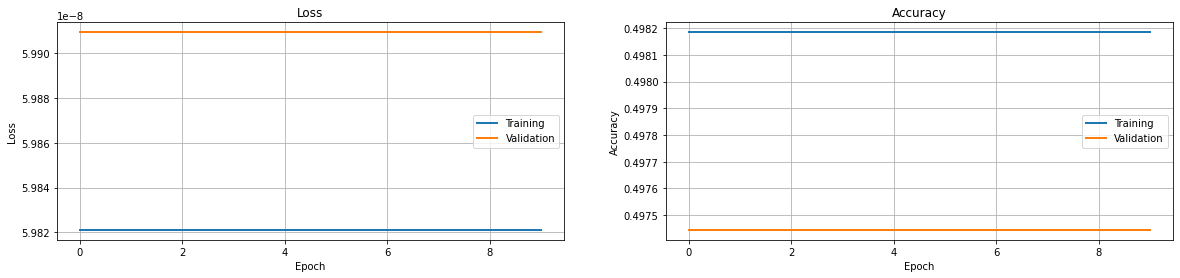

In [190]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [191]:
model3.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 3ms/step - loss: 5.9059e-08 - accuracy: 0.5046


[5.905850386511702e-08, 0.5045813918113708]

# Modelo 1 de Elena con otros datos

In [192]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=82, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [193]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [194]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 12s 5ms/step - loss: 0.5919 - binary_accuracy: 0.6712 - accuracy: 0.6712 - val_loss: 0.5315 - val_binary_accuracy: 0.7296 - val_accuracy: 0.7296
Epoch 2/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.5164 - binary_accuracy: 0.7446 - accuracy: 0.7446 - val_loss: 0.5278 - val_binary_accuracy: 0.7340 - val_accuracy: 0.7340
Epoch 3/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.5001 - binary_accuracy: 0.7517 - accuracy: 0.7517 - val_loss: 0.5280 - val_binary_accuracy: 0.7293 - val_accuracy: 0.7293
Epoch 4/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.4844 - binary_accuracy: 0.7607 - accuracy: 0.7607 - val_loss: 0.5334 - val_binary_accuracy: 0.7269 - val_accuracy: 0.7269
Epoch 5/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.4707 - binary_accuracy: 0.7679 - accuracy: 0.7679 - val_loss: 0.5375 - val_binary_accuracy: 0.7336 - val_accuracy: 0.

In [195]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 2ms/step - loss: 1.3192 - binary_accuracy: 0.6851 - accuracy: 0.6851


[1.3192397356033325, 0.6850759387016296, 0.6850759387016296]

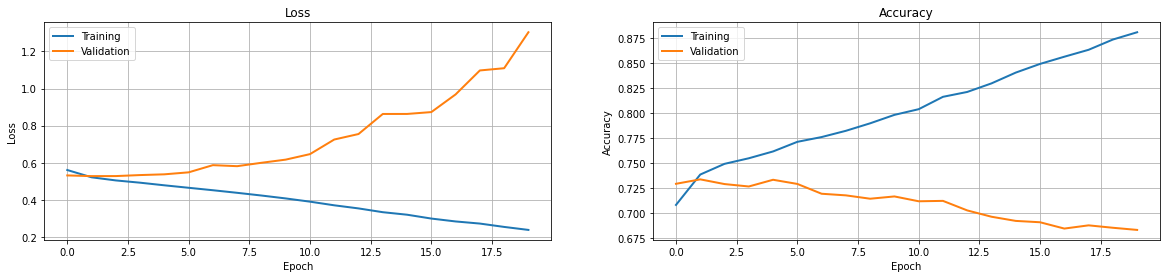

In [196]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Modelo 1 con Bidirectional 

In [197]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.5))
model.add(Dense(units=82, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [198]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [199]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 17s 8ms/step - loss: 0.5949 - binary_accuracy: 0.6669 - accuracy: 0.6669 - val_loss: 0.5267 - val_binary_accuracy: 0.7294 - val_accuracy: 0.7294
Epoch 2/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5134 - binary_accuracy: 0.7477 - accuracy: 0.7477 - val_loss: 0.5240 - val_binary_accuracy: 0.7322 - val_accuracy: 0.7322
Epoch 3/20
1859/1859 [==============================] - 14s 7ms/step - loss: 0.4990 - binary_accuracy: 0.7535 - accuracy: 0.7535 - val_loss: 0.5255 - val_binary_accuracy: 0.7314 - val_accuracy: 0.7314
Epoch 4/20
1859/1859 [==============================] - 14s 7ms/step - loss: 0.4853 - binary_accuracy: 0.7597 - accuracy: 0.7597 - val_loss: 0.5294 - val_binary_accuracy: 0.7320 - val_accuracy: 0.7320
Epoch 5/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.4683 - binary_accuracy: 0.7692 - accuracy: 0.7692 - val_loss: 0.5384 - val_binary_accuracy: 0.7262 - val_accuracy: 0.

In [200]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 1.4406 - binary_accuracy: 0.6823 - accuracy: 0.6823


[1.440642237663269, 0.6822518110275269, 0.6822518110275269]

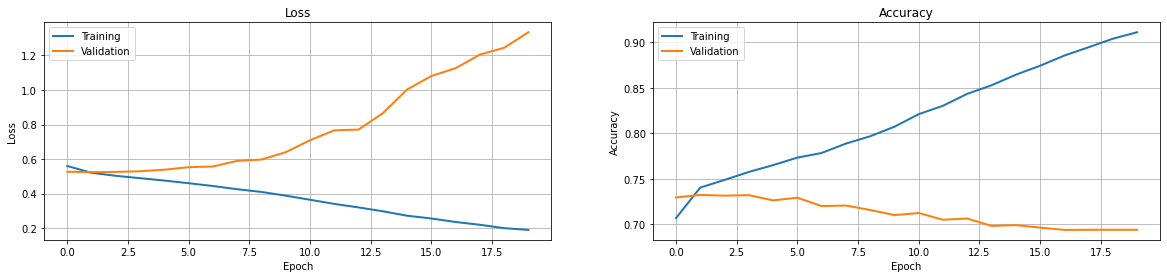

In [201]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Modelo 6 de Elena con otros datos

In [202]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [203]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [205]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 12s 6ms/step - loss: 0.6261 - binary_accuracy: 0.6378 - accuracy: 0.6378 - val_loss: 0.5388 - val_binary_accuracy: 0.7230 - val_accuracy: 0.7230
Epoch 2/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.5414 - binary_accuracy: 0.7373 - accuracy: 0.7373 - val_loss: 0.5305 - val_binary_accuracy: 0.7266 - val_accuracy: 0.7266
Epoch 3/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.5252 - binary_accuracy: 0.7491 - accuracy: 0.7491 - val_loss: 0.5287 - val_binary_accuracy: 0.7331 - val_accuracy: 0.7331
Epoch 4/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.5153 - binary_accuracy: 0.7502 - accuracy: 0.7502 - val_loss: 0.5329 - val_binary_accuracy: 0.7317 - val_accuracy: 0.7317
Epoch 5/20
1859/1859 [==============================] - 10s 5ms/step - loss: 0.4954 - binary_accuracy: 0.7614 - accuracy: 0.7614 - val_loss: 0.5344 - val_binary_accuracy: 0.7301 - val_accuracy: 0.

In [206]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 3ms/step - loss: 1.0911 - binary_accuracy: 0.6895 - accuracy: 0.6895


[1.0911160707473755, 0.6895318031311035, 0.6895318031311035]

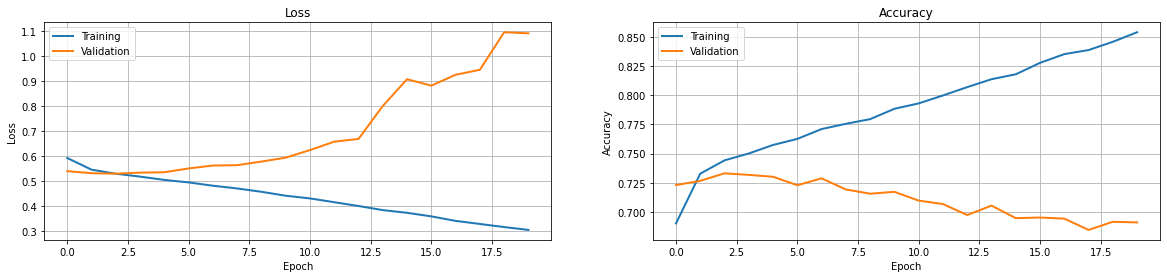

In [207]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Bidirectional Modelo arriba

# Modelo 5 de Elena con otros datos

In [209]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(LSTM(units=12))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [210]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [211]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 11s 5ms/step - loss: 0.6556 - binary_accuracy: 0.5918 - accuracy: 0.5918 - val_loss: 0.5390 - val_binary_accuracy: 0.7220 - val_accuracy: 0.7220
Epoch 2/20
1859/1859 [==============================] - 9s 5ms/step - loss: 0.5628 - binary_accuracy: 0.7291 - accuracy: 0.7291 - val_loss: 0.5283 - val_binary_accuracy: 0.7309 - val_accuracy: 0.7309
Epoch 3/20
1859/1859 [==============================] - 9s 5ms/step - loss: 0.5476 - binary_accuracy: 0.7396 - accuracy: 0.7396 - val_loss: 0.5261 - val_binary_accuracy: 0.7343 - val_accuracy: 0.7343
Epoch 4/20
1859/1859 [==============================] - 9s 5ms/step - loss: 0.5299 - binary_accuracy: 0.7428 - accuracy: 0.7428 - val_loss: 0.5295 - val_binary_accuracy: 0.7305 - val_accuracy: 0.7305
Epoch 5/20
1859/1859 [==============================] - 9s 5ms/step - loss: 0.5264 - binary_accuracy: 0.7477 - accuracy: 0.7477 - val_loss: 0.5340 - val_binary_accuracy: 0.7313 - val_accuracy: 0.7313

In [217]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 2ms/step - loss: 0.6078 - binary_accuracy: 0.7141 - accuracy: 0.7141


[0.6077851057052612, 0.7141333222389221, 0.7141333222389221]

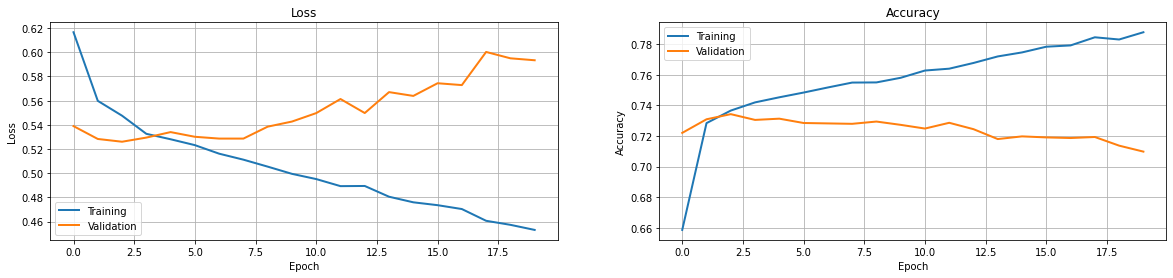

In [218]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Con bidirectional

In [219]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [220]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer='adam', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [221]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 16s 7ms/step - loss: 0.6445 - binary_accuracy: 0.6203 - accuracy: 0.6203 - val_loss: 0.5400 - val_binary_accuracy: 0.7279 - val_accuracy: 0.7279
Epoch 2/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5639 - binary_accuracy: 0.7322 - accuracy: 0.7322 - val_loss: 0.5341 - val_binary_accuracy: 0.7339 - val_accuracy: 0.7339
Epoch 3/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5563 - binary_accuracy: 0.7340 - accuracy: 0.7340 - val_loss: 0.5326 - val_binary_accuracy: 0.7345 - val_accuracy: 0.7345
Epoch 4/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5418 - binary_accuracy: 0.7421 - accuracy: 0.7421 - val_loss: 0.5293 - val_binary_accuracy: 0.7293 - val_accuracy: 0.7293
Epoch 5/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5371 - binary_accuracy: 0.7428 - accuracy: 0.7428 - val_loss: 0.5307 - val_binary_accuracy: 0.7304 - val_accuracy: 0.

In [222]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 1s 3ms/step - loss: 0.6274 - binary_accuracy: 0.7128 - accuracy: 0.7128


[0.6274280548095703, 0.7128153443336487, 0.7128153443336487]

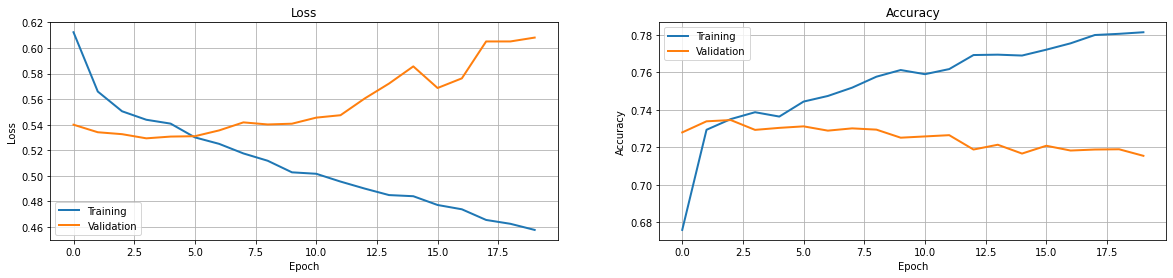

In [223]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## from logits = True

In [224]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [225]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [226]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 16s 7ms/step - loss: 0.6479 - binary_accuracy: 0.6008 - accuracy: 0.6008 - val_loss: 0.5377 - val_binary_accuracy: 0.7279 - val_accuracy: 0.7279
Epoch 2/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5583 - binary_accuracy: 0.7252 - accuracy: 0.7252 - val_loss: 0.5287 - val_binary_accuracy: 0.7327 - val_accuracy: 0.7327
Epoch 3/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5395 - binary_accuracy: 0.7351 - accuracy: 0.7351 - val_loss: 0.5292 - val_binary_accuracy: 0.7297 - val_accuracy: 0.7297
Epoch 4/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5290 - binary_accuracy: 0.7442 - accuracy: 0.7442 - val_loss: 0.5350 - val_binary_accuracy: 0.7306 - val_accuracy: 0.7306
Epoch 5/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5165 - binary_accuracy: 0.7476 - accuracy: 0.7476 - val_loss: 0.5268 - val_binary_accuracy: 0.7328 - val_accuracy: 0.

In [227]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.6627 - binary_accuracy: 0.7163 - accuracy: 0.7163


[0.6626832485198975, 0.7162671089172363, 0.7162671089172363]

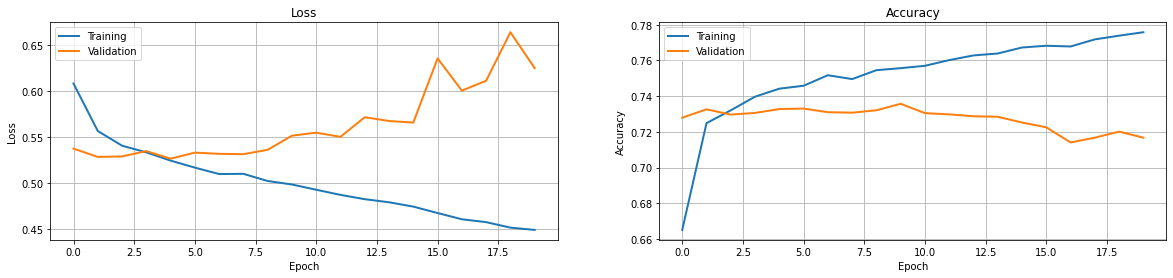

In [228]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Con rmsprop

In [233]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [234]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='rmsprop', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [235]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
1859/1859 [==============================] - 17s 7ms/step - loss: 0.6538 - binary_accuracy: 0.5954 - accuracy: 0.5954 - val_loss: 0.5382 - val_binary_accuracy: 0.7274 - val_accuracy: 0.7274
Epoch 2/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5533 - binary_accuracy: 0.7297 - accuracy: 0.7297 - val_loss: 0.5305 - val_binary_accuracy: 0.7292 - val_accuracy: 0.7292
Epoch 3/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5517 - binary_accuracy: 0.7305 - accuracy: 0.7305 - val_loss: 0.5352 - val_binary_accuracy: 0.7300 - val_accuracy: 0.7300
Epoch 4/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5429 - binary_accuracy: 0.7373 - accuracy: 0.7373 - val_loss: 0.5360 - val_binary_accuracy: 0.7339 - val_accuracy: 0.7339
Epoch 5/20
1859/1859 [==============================] - 13s 7ms/step - loss: 0.5473 - binary_accuracy: 0.7322 - accuracy: 0.7322 - val_loss: 0.5284 - val_binary_accuracy: 0.7305 - val_accuracy: 0.

In [236]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.5739 - binary_accuracy: 0.7244 - accuracy: 0.7244


[0.5739234089851379, 0.724425733089447, 0.724425733089447]

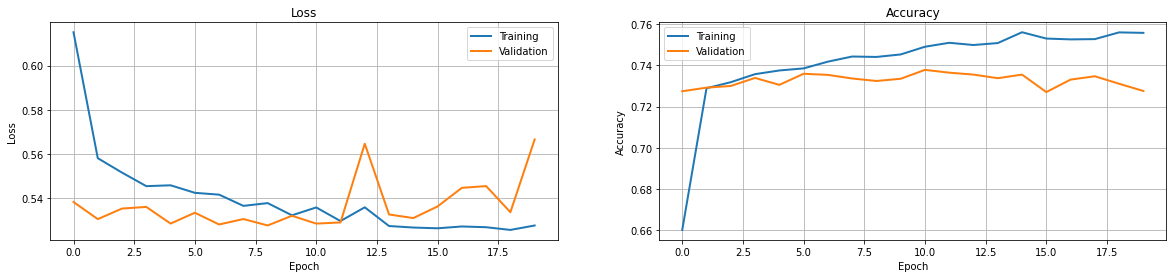

In [237]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Con batch size = 32

In [238]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [239]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='rmsprop', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [240]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
930/930 [==============================] - 12s 8ms/step - loss: 0.6594 - binary_accuracy: 0.5884 - accuracy: 0.5884 - val_loss: 0.5356 - val_binary_accuracy: 0.7288 - val_accuracy: 0.7288
Epoch 2/20
930/930 [==============================] - 7s 7ms/step - loss: 0.5594 - binary_accuracy: 0.7352 - accuracy: 0.7352 - val_loss: 0.5279 - val_binary_accuracy: 0.7324 - val_accuracy: 0.7324
Epoch 3/20
930/930 [==============================] - 7s 7ms/step - loss: 0.5429 - binary_accuracy: 0.7400 - accuracy: 0.7400 - val_loss: 0.5251 - val_binary_accuracy: 0.7285 - val_accuracy: 0.7285
Epoch 4/20
930/930 [==============================] - 7s 7ms/step - loss: 0.5426 - binary_accuracy: 0.7400 - accuracy: 0.7400 - val_loss: 0.5250 - val_binary_accuracy: 0.7285 - val_accuracy: 0.7285
Epoch 5/20
930/930 [==============================] - 7s 7ms/step - loss: 0.5385 - binary_accuracy: 0.7454 - accuracy: 0.7454 - val_loss: 0.5310 - val_binary_accuracy: 0.7321 - val_accuracy: 0.7321
Epoch 6/2

In [241]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.5734 - binary_accuracy: 0.7177 - accuracy: 0.7177


[0.5733956694602966, 0.717710554599762, 0.717710554599762]

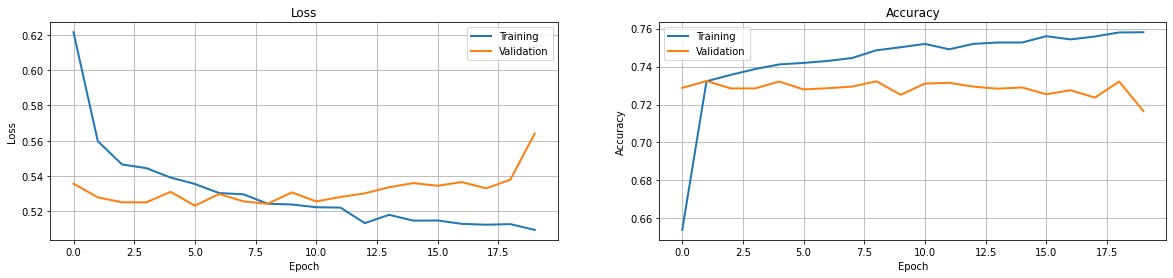

In [242]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Con batch size = 64

In [243]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [244]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='rmsprop', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [245]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
465/465 [==============================] - 7s 9ms/step - loss: 0.6717 - binary_accuracy: 0.5657 - accuracy: 0.5657 - val_loss: 0.5451 - val_binary_accuracy: 0.7275 - val_accuracy: 0.7275
Epoch 2/20
465/465 [==============================] - 3s 7ms/step - loss: 0.5646 - binary_accuracy: 0.7256 - accuracy: 0.7256 - val_loss: 0.5303 - val_binary_accuracy: 0.7310 - val_accuracy: 0.7310
Epoch 3/20
465/465 [==============================] - 4s 8ms/step - loss: 0.5459 - binary_accuracy: 0.7333 - accuracy: 0.7333 - val_loss: 0.5262 - val_binary_accuracy: 0.7335 - val_accuracy: 0.7335
Epoch 4/20
465/465 [==============================] - 3s 7ms/step - loss: 0.5439 - binary_accuracy: 0.7381 - accuracy: 0.7381 - val_loss: 0.5241 - val_binary_accuracy: 0.7324 - val_accuracy: 0.7324
Epoch 5/20
465/465 [==============================] - 3s 7ms/step - loss: 0.5340 - binary_accuracy: 0.7421 - accuracy: 0.7421 - val_loss: 0.5237 - val_binary_accuracy: 0.7335 - val_accuracy: 0.7335
Epoch 6/20

In [246]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.5504 - binary_accuracy: 0.7251 - accuracy: 0.7251


[0.5504375696182251, 0.7251161336898804, 0.7251161336898804]

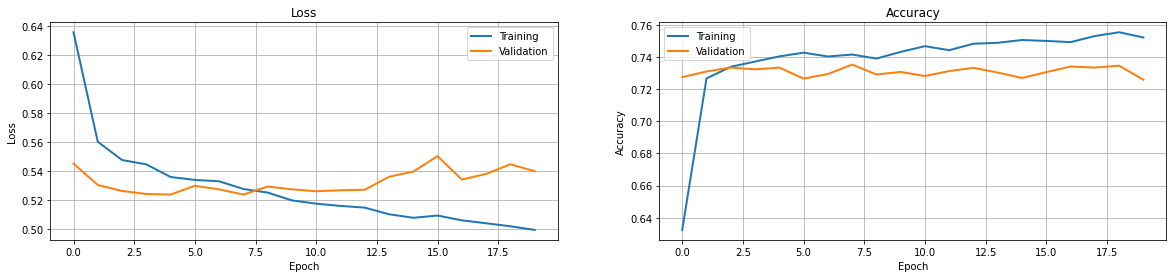

In [247]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

## Con más épocas = 50

In [248]:
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=12, trainable=True))
model.add(Bidirectional(LSTM(units=12)))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [249]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='rmsprop', 
              metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [250]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
465/465 [==============================] - 7s 9ms/step - loss: 0.6791 - binary_accuracy: 0.5546 - accuracy: 0.5546 - val_loss: 0.5454 - val_binary_accuracy: 0.7250 - val_accuracy: 0.7250
Epoch 2/50
465/465 [==============================] - 3s 7ms/step - loss: 0.5665 - binary_accuracy: 0.7302 - accuracy: 0.7302 - val_loss: 0.5318 - val_binary_accuracy: 0.7308 - val_accuracy: 0.7308
Epoch 3/50
465/465 [==============================] - 3s 7ms/step - loss: 0.5528 - binary_accuracy: 0.7359 - accuracy: 0.7359 - val_loss: 0.5267 - val_binary_accuracy: 0.7340 - val_accuracy: 0.7340
Epoch 4/50
465/465 [==============================] - 3s 7ms/step - loss: 0.5400 - binary_accuracy: 0.7428 - accuracy: 0.7428 - val_loss: 0.5232 - val_binary_accuracy: 0.7322 - val_accuracy: 0.7322
Epoch 5/50
465/465 [==============================] - 3s 7ms/step - loss: 0.5348 - binary_accuracy: 0.7411 - accuracy: 0.7411 - val_loss: 0.5228 - val_binary_accuracy: 0.7320 - val_accuracy: 0.7320
Epoch 6/50

In [251]:
model.evaluate(x=X_test, y=y_test)

498/498 [==============================] - 2s 3ms/step - loss: 0.6378 - binary_accuracy: 0.7139 - accuracy: 0.7139


[0.6378198266029358, 0.7138822674751282, 0.7138822674751282]

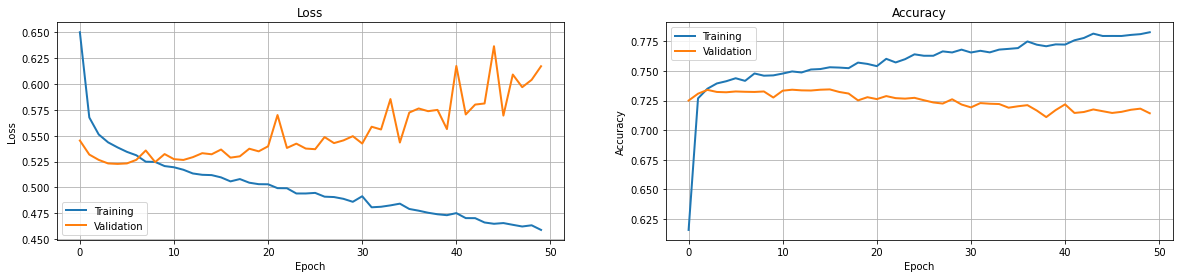

In [252]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()